In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split

## Load Train and Test Datasets

In [2]:
# Load training data
df_train = pd.read_csv('../../0_Datasets/NSL-KDD/train.csv')

In [3]:
# Load testing data
df_test = pd.read_csv('../../0_Datasets/NSL-KDD/test.csv')

In [4]:
X_train = df_train.drop(['binary_attack'], axis=1)  # Features
y_train = df_train['binary_attack']  # Target variable

In [5]:
X_test = df_test.drop(['binary_attack'], axis=1)  # Features
y_test = df_test['binary_attack']  # Target variable

## Load Model

In [6]:
# Save the trained model to a specific folder
model_folder = "../../2_Modeling_Phase/Saved_Models/"
model_filename = "NSL-KDD_XGBoost.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

---

# Feature Importance

In [7]:
feature_names = df_train.columns
feature_names = feature_names[:-1]

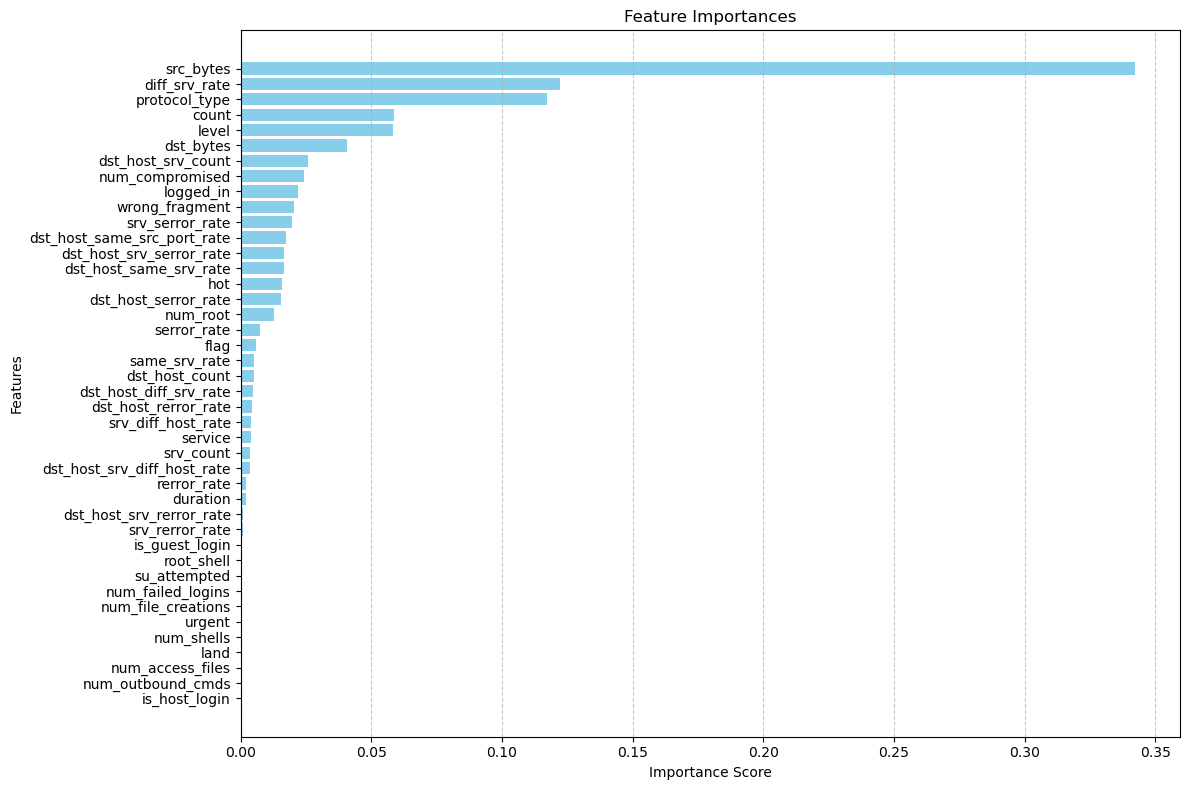

In [8]:
# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar plot
ax.barh(range(X_train.shape[1]), importances[indices], color="skyblue")

# Set y-axis labels
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(feature_names[indices])

# Set title and labels
ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

# Invert y-axis for better readability
ax.invert_yaxis()

# Add grid for better visualization
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

## Imodels

In [9]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: total: 0 ns
Wall time: 5.93 ms


,feat_names,feature,importance_gini,importance_gini_pct
0,src_bytes,4,0.342388,1.000000
1,diff_srv_rate,29,0.122204,0.976190
2,protocol_type,1,0.117225,0.952381
3,count,22,0.058834,0.928571
4,level,41,0.058354,0.904762
5,dst_bytes,5,0.040676,0.880952
6,dst_host_srv_count,32,0.025645,0.857143
7,num_compromised,12,0.024098,0.833333
8,logged_in,11,0.021875,0.809524
9,wrong_fragment,7,0.020307,0.785714


## Shap

In [10]:
#pip install shap

## InterpretML

In [11]:
#pip install interpret

In [12]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test, feature_names=feature_names)

explanation = msa.explain_global()

# Extracting the Morris sensitivity results as a DataFrame
sensitivity_df = pd.DataFrame(explanation.data()["scores"], index=feature_names)
sorted_sensitivity_df = sensitivity_df.sort_values(by=sensitivity_df.columns[0], ascending=False)
print(sorted_sensitivity_df)

show(explanation, max_features=len(feature_names))

C:\Users\ivoafonsobispo\anaconda3\Lib\site-packages\SALib\util\__init__.py:302: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_group_names = pd.unique(groups)
C:\Users\ivoafonsobispo\anaconda3\Lib\site-packages\SALib\util\__init__.py:302: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_group_names = pd.unique(groups)


CPU times: total: 4.58 s
Wall time: 565 ms
                                    0
protocol_type                0.297954
level                        0.252549
dst_host_rerror_rate         0.212665
dst_host_srv_serror_rate     0.161562
dst_host_same_srv_rate       0.104853
src_bytes                    0.100674
dst_host_srv_count           0.082951
service                      0.079748
dst_host_srv_rerror_rate     0.071259
dst_host_serror_rate         0.058868
dst_bytes                    0.052276
dst_host_same_src_port_rate  0.051763
wrong_fragment               0.048931
dst_host_count               0.047002
dst_host_diff_srv_rate       0.045608
count                        0.044929
serror_rate                  0.043207
flag                         0.038664
srv_count                    0.036861
same_srv_rate                0.032935
hot                          0.029844
duration                     0.029349
diff_srv_rate                0.023188
dst_host_srv_diff_host_rate  0.022402
srv_ser

<!-- http://127.0.0.1:7632/2332809232336/ -->

## LOFO

In [13]:
#pip install lofo-importance

In [14]:
from lofo import LOFOImportance, Dataset
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None) # Don't shuffle to keep the time split validation

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    
    return importance

%time importance = calculate_lofo_importance(df=df_test, target_column="binary_attack", feature_names=feature_names)

importance

C:\Users\ivoafonsobispo\anaconda3\Lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points 

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2942
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2942
[LightGBM] [Info] Number of data points 

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2750
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2752
[LightGBM] [Info] Number of data points 

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points 

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2734
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2734
[LightGBM] [Info] Number of data points 

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2853
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points 

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2705
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2944
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2956
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2895
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2956
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2855
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2856
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove th

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
19,level,4.398744e-04,0.000133,3.749650e-04,5.294025e-04,0.000257,5.976480e-04
37,dst_host_srv_diff_host_rate,4.028594e-05,0.000064,3.219689e-06,-8.972923e-07,0.000151,7.557867e-06
13,service,3.125463e-05,0.000055,1.957571e-05,4.358277e-06,0.000123,-2.177691e-05
23,dst_host_same_srv_rate,2.844351e-05,0.000056,6.439379e-07,-6.793785e-06,0.000126,-5.636376e-06
30,dst_host_srv_serror_rate,1.635802e-05,0.000035,-3.348477e-06,3.845539e-07,0.000076,-7.814066e-06
41,dst_host_serror_rate,1.297064e-05,0.000016,3.863627e-07,-6.409231e-07,0.000040,1.242565e-05
3,dst_host_srv_count,1.136212e-05,0.000016,-5.022716e-06,1.345938e-05,0.000037,2.561989e-07
10,logged_in,1.003652e-05,0.000023,4.378778e-06,-1.538215e-06,0.000048,-1.101655e-05
27,rerror_rate,8.102972e-06,0.000021,-2.575752e-06,0.000000e+00,0.000045,-9.607458e-06
0,flag,6.723325e-06,0.000013,5.022716e-06,5.127385e-07,0.000029,-7.429768e-06
